In [5]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy
from scipy import stats as scipy_stats
from matplotlib import pyplot

from lib import config
from lib import stats


pyplot.style.use(config.glyfish_style)


/Users/troy/Develop/gly.fish/alpaca/notebooks


In [7]:
def brownian_noise(n):
    return numpy.random.normal(0.0, 1.0, n)

def bivariate_normal_pdf(x, y, μ, Ω):
    pos = numpy.empty(x.shape+(2,))
    pos[:,:,0] = x
    pos[:,:,1] = y
    return scipy_stats.multivariate_normal.pdf(pos, μ, Ω)

def multivariate_normal_sample(μ, Ω, n):
    return numpy.random.multivariate_normal(μ, Ω, n)

def cholesky_decompose(Ω):
    return numpy.linalg.cholesky(Ω)

def cholesky_multivariate_normal_sample(μ, Ω, n):
    l = cholesky_decompose(Ω)
    _, m = l.shape
    samples = numpy.zeros((n,2))
    for i in range(n):
        bn = numpy.matrix(brownian_noise(m))
        s = l*bn.T
        for j in range(m):
            samples[i][j] = s[j,0] + μ[j]
    return samples

def bivariate_pdf_mesh(μ, Ω, n):
    σ = max(Ω[0][0], Ω[1][1])
    δ = 6.0*σ/n
    x1 = -3.0*σ + μ[0]
    x2 = 3.0*σ + μ[0]
    y1 = -3.0*σ + μ[1]
    y2 = 3.0*σ + μ[1]
    x, y = numpy.mgrid[x1:x2:δ, y1:y2:δ]
    return (x, y)

def bivariate_pdf_contour_plot(μ, Ω, n, contour_values):
    x, y = bivariate_pdf_mesh(μ, Ω, n)
    f = bivariate_normal_pdf(x, y, μ, Ω)
    figure, axis = pyplot.subplots(figsize=(9, 9))
    axis.set_xlabel(r"$x$")
    axis.set_ylabel(r"$y$")
    σ = max(Ω[0][0], Ω[1][1])
    x1 = -3.2*σ + μ[0]
    x2 = 3.2*σ + μ[0]
    y1 = -3.2*σ + μ[1]
    y2 = 3.2*σ + μ[1]
    axis.set_xlim([x1, x2])
    axis.set_ylim([y1, y2])
    title = f"Bivariate Normal Distribution: γ={format(Ω[0][1], '2.2f')}, " + \
             r"$σ_x$=" + f"{format(Ω[0][0], '2.2f')}, " + r"$σ_y$=" + \
             f"{format(Ω[1][1], '2.2f')}"
    axis.set_title(title)
    contour = axis.contour(x, y, f, contour_values, cmap=config.contour_color_map)
    axis.clabel(contour, contour.levels[::2], fmt="%.3f", inline=True, fontsize=15)

def bivariate_pdf_samples_plot(samples, μ, Ω, n, contour_values):
    x, y = bivariate_pdf_mesh(μ, Ω, n)
    f = bivariate_normal_pdf(x, y, μ, Ω)
    figure, axis = pyplot.subplots(figsize=(9, 9))
    axis.set_xlabel(r"$x$")
    axis.set_ylabel(r"$y$")
    σ = max(Ω[0][0], Ω[1][1])
    x1 = -3.2*σ + μ[0]
    x2 = 3.2*σ + μ[0]
    y1 = -3.2*σ + μ[1]
    y2 = 3.2*σ + μ[1]
    axis.set_xlim([x1, x2])
    axis.set_ylim([y1, y2])
    bins = [numpy.linspace(x1, x2, 100), numpy.linspace(y1, y2, 100)]
    title = f"Bivariate Normal Distribution: γ={format(Ω[0][1], '2.2f')}, " + \
             r"$σ_x$=" + f"{format(Ω[0][0], '2.2f')}, " + r"$σ_y$=" + \
             f"{format(Ω[1][1], '2.2f')}"
    axis.set_title(title)
    _, _, _, image = axis.hist2d(samples[:,0], samples[:,1], normed=True, bins=bins, cmap=config.alternate_color_map)
    contour = axis.contour(x, y, f, contour_values, cmap=config.contour_color_map)
    axis.clabel(contour, contour.levels[::2], fmt="%.3f", inline=True, fontsize=15)
    figure.colorbar(image)

def cumulative_mean(title, samples, μ, file):
    nsample = len(samples)
    time = numpy.linspace(0, nsample-1, nsample)
    mean = stats.cummean(samples)
    figure, axis = pyplot.subplots(figsize=(10, 7))
    axis.set_xlabel("Time")
    axis.set_ylabel(r"$μ$")
    axis.set_title(title, y=1.05)
    axis.set_ylim([min(mean[10:]), max(mean[10:])])
    axis.set_xlim([10.0, nsample])
    axis.semilogx(time, numpy.full((len(time)), μ), label="Target μ", color="#000000")
    axis.semilogx(time, mean)

def cumulative_standard_deviation(title, samples, σ, file):
    nsample = len(samples)
    time = numpy.linspace(0, nsample-1, nsample)
    sigma = stats.cumsigma(samples)
    figure, axis = pyplot.subplots(figsize=(10, 7))
    axis.set_xlabel("Time")
    axis.set_ylabel(r"$σ$")
    axis.set_title(title, y=1.05)
    axis.set_ylim([min(sigma[10:]), max(sigma[10:])])
    axis.set_xlim([10.0, nsample])
    axis.semilogx(time, numpy.full((len(time)), σ), label="Target σ", color="#000000")
    axis.semilogx(time, sigma)

def cumulative_correlation(title, x, y, γ, file):
    nsample = len(x)
    time = numpy.linspace(0, nsample-1, nsample)
    cov = stats.cum_covariance(x, y)
    sigmax = stats.cumsigma(x)
    sigmay = stats.cumsigma(y)
    γt = numpy.zeros(len(cov))
    for i in range(1, len(cov)):
        γt[i] = cov[i]/(sigmax[i]*sigmay[i])
    figure, axis = pyplot.subplots(figsize=(10, 7))
    axis.set_xlabel("Time")
    axis.set_ylabel(r"$γ$")
    axis.set_title(title, y=1.05)
    axis.set_ylim([-1.1, 1.1])
    axis.set_xlim([10.0, nsample])
    axis.semilogx(time, numpy.full((len(time)), γ), label="Target γ", color="#000000")
    axis.semilogx(time, γt)

def timeseries_plot(samples, ylabel, title):
    nsample, nplot = samples.shape
    ymin = numpy.amin(samples)
    ymax = numpy.amax(samples)
    figure, axis = pyplot.subplots(nplot, sharex=True, figsize=(12, 9))
    axis[0].set_title(title)
    axis[nplot-1].set_xlabel(r"$t$")
    time = numpy.linspace(0, nsample-1, nsample)
    for i in range(nplot):
        axis[i].set_ylabel(ylabel[i])
        axis[i].set_ylim([ymin, ymax])
        axis[i].set_xlim([0.0, nsample])
        axis[i].plot(time, samples[:,i], lw=1.0)


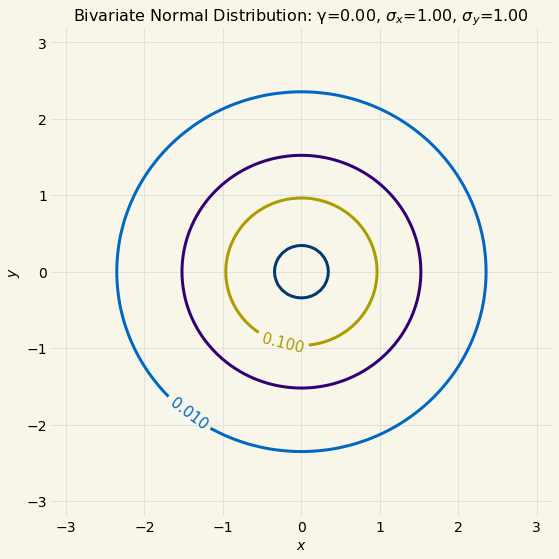

In [8]:
μ = [0.0, 0.0]
Ω = [[1.0, 0.0], [0.0, 1.0]]
n = 100

bivariate_pdf_contour_plot(μ, Ω, n, [0.01, 0.05, 0.1, 0.15, 0.2])

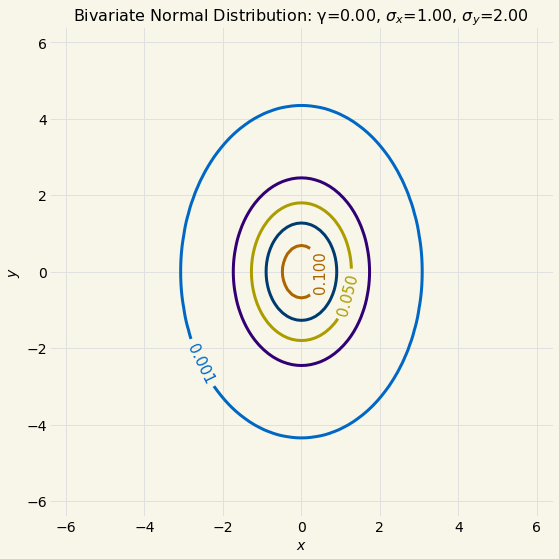

In [9]:
μ = [0.0, 0.0]
Ω = [[1.0, 0.0], [0.0, 2.0]]
n = 100

bivariate_pdf_contour_plot(μ, Ω, n, [0.001, 0.025, 0.05, 0.075, 0.1])